### Import Required Packages and Set Options

In [1]:
import os
import re
import sys
import git
from datetime import datetime

import numpy as np
import numba as nb
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_style('whitegrid')
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
# plt.rcParams

#### Put the Main Package Library on the PYTHONPATH

In [3]:
git_repo = git.Repo('.', search_parent_directories=True)
git_root = git_repo.git.rev_parse('--show-toplevel')

sys.path[0] = git_root
sys.path[0]

'/Users/ericlundquist/Repos/rankfm'

#### Dynamically Re-Load all Package Modules on Execution

In [4]:
%load_ext autoreload
%autoreload 2

from rankfm.rankfm import RankFM
from rankfm.evaluation import hit_rate, reciprocal_rank, discounted_cumulative_gain, precision, recall, diversity

#### Set File Path Constants

In [5]:
data_path = os.path.join(git_root, "data/examples")
print("\n".join([git_root, data_path]))

/Users/ericlundquist/Repos/rankfm
/Users/ericlundquist/Repos/rankfm/data/examples


### Load Example Data

#### Load Interactions Data
* `interactions` must be a `pd.dataframe` or `np.ndarray` with columns: `[user_id, item_id]` when used for model fitting
* the rows of `interactions` should represent observed or implied positive feedback for the user/item pair
* examples of implicit feedback include product purchases, movie/article views, page views, clicks, etc.
* the `user_id` and/or `item_id` identifiers can be arbitrary integers or even strings as long as they are unique identifiers for users/items
* RankFM internally maps raw `user_id` and `item_id` values to zero-based index positions but maps all output back to original identifier values
* it is recommended you perform any cross-validation or data splitting strategy requiring additional columns prior to preparing the interaction data for model fitting
* in this example we'll assume all observed movie ratings count as positive implicit feedback regardless of numerical rating `[1-5]`
* this most closely represents the intended data and modeling context for which RankFM was designed (implicit preferences recommendation)

In [6]:
interactions = pd.read_csv(os.path.join(data_path, 'ML_1M_RATINGS.csv'))
interactions.head()

,user_id,item_id,rating,timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


#### Load User Features
* `user_features` must be a `pd.dataframe` or `np.ndarray` with columns: `[user_id, uf_1, ... , uf_n]`
* the first column must be the `user_id` and the set of `user_id` values must match the unique users found in `interactions`
* the additional columns should be user attributes/features that can be coerced to `float32` data type (i.e. no strings)
* care should be taken to scale any continuous features prior to model fitting for numerical stability - often dummy/tag features work best

In [7]:
user_features = pd.read_csv(os.path.join(data_path, 'ML_1M_USERS.csv'))
user_features.head()

,user_id,gender__F,gender__M,agegrp__1,agegrp__18,agegrp__25,agegrp__35,agegrp__45,agegrp__50,agegrp__56,...,occupation__11,occupation__12,occupation__13,occupation__14,occupation__15,occupation__16,occupation__17,occupation__18,occupation__19,occupation__20
0,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,3,0,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,4,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


#### Load Item Features
* `item_features` must be a `pd.dataframe` or `np.ndarray` with columns: `[item_id, uf_1, ... , uf_n]`
* the first column must be the `item_id` and the set of `item_id` values must match the unique items found in `interactions`
* the additional columns should be item attributes/features that can be coerced to `float32` data type (i.e. no strings)
* care should be taken to scale any continuous features prior to model fitting for numerical stability - often dummy/tag features work best

In [8]:
item_features = pd.read_csv(os.path.join(data_path, 'ML_1M_ITEMS.csv'))
item_features.head()

,item_id,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmnoir,horror,musical,mystery,romance,scifi,thriller,war,western
0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Load Item Names
* these won't be used for model fitting, but are important when reviewing the output for face validity
* also analyzing recommended/similar movies isn't any fun if you can't see the titles!

In [9]:
item_names = pd.read_csv(os.path.join(data_path, 'ML_1M_ITEM_NAMES.csv'))
item_names.head()

,item_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


#### Check Matrix/Vector Dimensions

In [10]:
unique_users = interactions.user_id.nunique()
unique_items = interactions.item_id.nunique()

print("interactions shape: {}".format(interactions.shape))
print("interactions unique users: {}".format(interactions.user_id.nunique()))
print("interactions unique items: {}".format(interactions.item_id.nunique()))

print("user features users:", interactions.user_id.nunique())
print("item features items:", interactions.item_id.nunique())

interactions shape: (1000209, 4)
interactions unique users: 6040
interactions unique items: 3706
user features users: 6040
item features items: 3706


#### Evaluate Interaction Matrix Sparsity

In [11]:
sparsity = 1 - (len(interactions) / (unique_users * unique_items))
print("interaction matrix sparsity: {}%".format(round(100 * sparsity, 1)))

interaction matrix sparsity: 95.5%


#### Split Interactions Data into (Train, Valid) for Model Evaluation
* we'll randomly split off 25% of the observed user/item interactions for model validation
* take care to note any users/items in the validation set not appearing in the training set
* for model fitting we'll have to unify the set of users/items across `interactions`, `user_features`, `item_features`
* for scoring/recommendation RankFM has the `cold_start` option to either drop unseen users/items or set model output to np.nan

In [47]:
np.random.seed(1492)
interactions['random'] = np.random.random(size=len(interactions))
test_pct = 0.25

In [48]:
train_mask = interactions['random'] <  (1 - test_pct)
valid_mask = interactions['random'] >= (1 - test_pct)

interactions_train = interactions[train_mask][['user_id', 'item_id']]
interactions_valid = interactions[valid_mask][['user_id', 'item_id']]

train_users = np.sort(interactions_train.user_id.unique())
valid_users = np.sort(interactions_valid.user_id.unique())
cold_start_users = set(valid_users) - set(train_users)

train_items = np.sort(interactions_train.item_id.unique())
valid_items = np.sort(interactions_valid.item_id.unique())
cold_start_items = set(valid_items) - set(train_items)

print("train shape: {}".format(interactions_train.shape))
print("valid shape: {}".format(interactions_valid.shape))

print("train users: {}".format(len(train_users)))
print("valid users: {}".format(len(valid_users)))
print("cold-start users: {}".format(cold_start_users))

print("train items: {}".format(len(train_items)))
print("valid items: {}".format(len(valid_items)))
print("cold-start items: {}".format(cold_start_items))

train shape: (749724, 2)
valid shape: (250485, 2)
train users: 6040
valid users: 6038
cold-start users: set()
train items: 3666
valid items: 3531
cold-start items: {3202, 2563, 644, 3460, 3209, 3722, 139, 396, 651, 1555, 1434, 1915, 1830, 2217, 2218, 687, 1842, 2742, 1851, 2619, 576, 3321, 3277, 3323, 3280, 601, 3290, 3164, 989, 865, 226, 3172, 1386, 878, 3187, 758, 3065, 763, 2556, 127}


In [49]:
user_features = user_features[user_features.user_id.isin(train_users)]
item_features = item_features[item_features.item_id.isin(train_items)]
user_features.shape, item_features.shape

((6040, 31), (3666, 19))

### Fit the Model on the Training Data and Evaluate Out-of-Sample Performance Metrics

#### Initialize the Model Object

In [66]:
model = RankFM(factors=10, regularization=0.01, sigma=0.1, learning_rate=0.10, learning_schedule='invscaling', learning_exponent=0.25)
model

#### Fit the Model on the Training Data
* each epoch represents one full pass through all observed user/item interactions in the training data
* the `verbose` flag will print the current training epoch as well as the epoch's penalized log-likelihood value
* the training algorithm attempts to maximize the model's log likelihood which represents user preferences for observed items over unobserved items
* the log likelihood isn't 1:1 correlated with our recommendation/ranking evaluation metrics but serves as a decent proxy for training progress 

In [67]:
%%time
model.fit(interactions_train, epochs=25, verbose=True)


training epoch: 0
log likelihood: -295419.1

training epoch: 1
log likelihood: -260082.84

training epoch: 2
log likelihood: -233097.82

training epoch: 3
log likelihood: -215836.6

training epoch: 4
log likelihood: -206411.81

training epoch: 5
log likelihood: -199050.39

training epoch: 6
log likelihood: -193680.26

training epoch: 7
log likelihood: -189794.95

training epoch: 8
log likelihood: -187142.13

training epoch: 9
log likelihood: -185668.73

training epoch: 10
log likelihood: -184382.08

training epoch: 11
log likelihood: -182320.4

training epoch: 12
log likelihood: -182067.53

training epoch: 13
log likelihood: -181315.43

training epoch: 14
log likelihood: -180496.09

training epoch: 15
log likelihood: -179845.83

training epoch: 16
log likelihood: -179139.57

training epoch: 17
log likelihood: -178675.36

training epoch: 18
log likelihood: -178152.59

training epoch: 19
log likelihood: -178555.42

training epoch: 20
log likelihood: -177980.04

training epoch: 21
log li

#### Generate Model Scores for Validation Interactions
* the `predict()` method generates real-valued model scores for user/item pairs
* specify scoring interactions or user/item pairs the same way as training: `[user_id, item_id]`
* the scores generated are those produced by the underlying second-degree factorization machine model
* the `cold_start` option allows you to either generate missing values for unseen users/items or drop them from scoring output

In [80]:
valid_scores = model.predict(interactions_valid, cold_start='nan') 
print(valid_scores.shape)
pd.Series(valid_scores).describe()

(250485,)


count    250437.000000
mean          1.443531
std           1.053365
min          -3.246550
25%           0.788618
50%           1.571644
75%           2.226128
max           4.273824
dtype: float64

#### Generate TopN Recommendations for Validation Users
* instead of having to generate predictions for all user/item pairs the `recommend_for_users()` method lets you generate the topN recommended items for each user
* the output is a pd.dataframe where the index values are `user_id` and the columns are recommended items in descending order (first column is best item)
* additionally there's an option `filter_previous` to exclude any items already observed during training for the user from being recommended
* as with `predict()` there's a `cold_start` option to either fill with missing or drop recommendations for any user not found in training

In [81]:
valid_recommendations = model.recommend_for_users(valid_users, n_items=10, filter_previous=True, cold_start='nan')
valid_recommendations.head()

,0,1,2,3,4,5,6,7,8,9
1,34,296,2858,1282,2396,2324,3751,593,2078,318
2,1610,527,296,1617,1270,590,608,1097,1291,1036
3,457,589,1036,110,2571,2028,1197,1610,356,1214
4,1270,589,1210,480,541,1196,1387,924,593,1198
5,3160,2692,2599,1639,265,1682,223,2324,3481,247


#### Evaluate Model Performance on the Validation Data

##### Specify Number of Recommended Items
* here we'll look at model performance in terms of validation metrics wrt the top 10 recommended items for each user
* it's good to compare validation metrics against the best unpersonalized recommendations: overall item popularity rankings from the training data

In [82]:
k = 10

##### Generate Pure-Popularity Baselines

In [83]:
most_popular = interactions_train.groupby('item_id')['user_id'].count().sort_values(ascending=False)[:k]
most_popular

item_id
2858    2545
260     2254
1196    2230
1210    2178
589     2002
2028    1980
480     1974
1270    1939
2571    1921
608     1910
Name: user_id, dtype: int64

In [84]:
test_user_items = interactions_valid.groupby('user_id')['item_id'].apply(set).to_dict()
test_recommends = model.recommend_for_users(list(test_user_items.keys()), cold_start='drop')
test_user_items = {key: val for key, val in test_user_items.items() if key in test_recommends.index}

base_pre = round(np.mean([len(set(most_popular.index) & set(val)) / len(set(most_popular.index)) for key, val in test_user_items.items()]), 3)
base_rec = round(np.mean([len(set(most_popular.index) & set(val)) / len(set(val))                for key, val in test_user_items.items()]), 3)

print("number of test users: {}".format(len(test_user_items)))
print("baseline (popularity) precision: {}".format(base_pre))
print("baseline (popularity) recall: {}".format(base_rec))

number of test users: 6038
baseline (popularity) precision: 0.116
baseline (popularity) recall: 0.046


##### Generate Model Validation Metrics
* the RankFM package comes with a number of utility functions to evaluate model performance
* these functions cover common validation metrics for recommendation/ranking models with implicit feedback data
* all evaluation functions have the same interface and require a previously fit RankFM model
    * `hit_rate`: the proportion of users with any relevant recommended item
    * `reciprocal_rank`: the inverse rank of the first relevant recommended item (or zero if no matches)
    * `discounted_cumulative_gain`: the sum of the inverse log-scaled ranks for relevant recommended items
    * `precision`: the number of relevant recommended items / number of recommended items
    * `recall`: the number of relevant recommended items / number of relevant items

In [73]:
model_hit_rate = hit_rate(model, interactions_valid, k=k)
model_reciprocal_rank = reciprocal_rank(model, interactions_valid, k=k)
model_dcg = discounted_cumulative_gain(model, interactions_valid, k=k)
model_precision = precision(model, interactions_valid, k=k)
model_recall = recall(model, interactions_valid, k=k)

In [74]:
print("hit_rate: {:.3f}".format(model_hit_rate))
print("reciprocal_rank: {:.3f}".format(model_reciprocal_rank))
print("dcg: {:.3f}".format(model_dcg, 3))
print("precision: {:.3f}".format(model_precision))
print("recall: {:.3f}".format(model_recall))

hit_rate: 0.764
reciprocal_rank: 0.329
dcg: 0.704
precision: 0.152
recall: 0.068


#### Assess Recommendation Diversity
* in addition to relevance, it's often important to assess the diversity of model recommendations
* in other words, how many items are getting recommended, what's the percentage of users getting recommended top items, etc.
* this is an important component of personalization and high diversity will help prevent the harmful rich-get-richer feedback loop 

In [85]:
recommendation_diversity = diversity(model, interactions_valid, k=k)
recommendation_diversity.head(10)

,item_id,cnt_users,pct_users
0,2858,2672,0.442531
1,1270,2244,0.371646
2,589,1683,0.278735
3,593,1579,0.261510
4,480,1534,0.254058
5,296,1527,0.252898
6,608,1246,0.206360
7,260,1226,0.203047
8,110,1204,0.199404
9,457,1049,0.173733


In [86]:
top_items = pd.merge(item_names, recommendation_diversity, on='item_id', how='inner')
top_items = top_items.set_index('item_id').loc[recommendation_diversity.item_id].reset_index()
top_items = top_items[['item_id', 'cnt_users', 'pct_users', 'title', 'genres']]
top_items.head(10)

,item_id,cnt_users,pct_users,title,genres
0,2858,2672,0.442531,American Beauty (1999),Comedy|Drama
1,1270,2244,0.371646,Back to the Future (1985),Comedy|Sci-Fi
2,589,1683,0.278735,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller
3,593,1579,0.261510,"Silence of the Lambs, The (1991)",Drama|Thriller
4,480,1534,0.254058,Jurassic Park (1993),Action|Adventure|Sci-Fi
5,296,1527,0.252898,Pulp Fiction (1994),Crime|Drama
6,608,1246,0.206360,Fargo (1996),Crime|Drama|Thriller
7,260,1226,0.203047,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi
8,110,1204,0.199404,Braveheart (1995),Action|Drama|War
9,457,1049,0.173733,"Fugitive, The (1993)",Action|Thriller


In [87]:
coverage = np.mean(recommendation_diversity['cnt_users'] > 0)
print("percentage of items recommended to at least one user: {:.3f}".format(coverage))

percentage of items recommended to at least one user: 0.239


In [88]:
nonzero_users = recommendation_diversity[recommendation_diversity.cnt_users > 0]
entropy = -np.sum(nonzero_users['pct_users'] * np.log2(nonzero_users['pct_users']))
print("entropy value of recommended items: {:.3f}".format(entropy))

entropy value of recommended items: 41.670


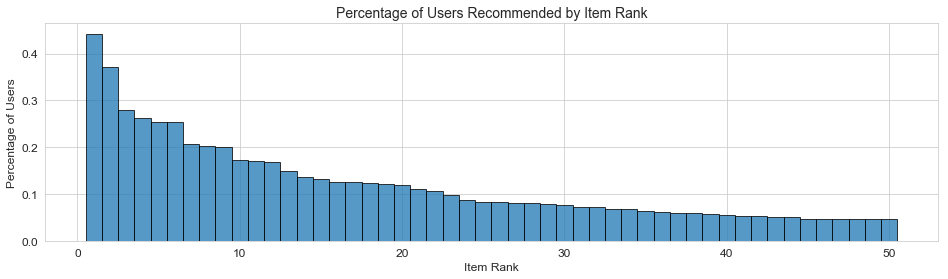

In [89]:
N = 50
fig, axes = plt.subplots(1, 1, figsize=[16, 4])

topN = recommendation_diversity.iloc[:N, :]
axes.bar(topN.index.values + 1, topN.pct_users, width=1, edgecolor='black', alpha=0.75)
axes.set(xlabel='Item Rank', ylabel='Percentage of Users', title='Percentage of Users Recommended by Item Rank')
plt.show()

### Calculate the Most Similar Items to a Given Item
* the model's representation of users/items in latent factor space allows for the calculation of item-item similarity with simple dot products
* in many contexts it's useful to serve similar items either for user acceptance or for contextual recommendations 
* one example might be recommending the user a list of movies to watch next after he/she has just finished watching a given movie

In [90]:
random_user = np.random.choice(interactions_valid.user_id.unique())
print("random user: {}".format(random_user))

random user: 4179


In [91]:
random_user_recs = valid_recommendations.loc[random_user]
random_user_recs = item_names[item_names.item_id.isin(random_user_recs)].set_index('item_id').loc[random_user_recs]
random_user_recs

,title,genres
item_id,,
2396,Shakespeare in Love (1998),Comedy|Romance
1097,E.T. the Extra-Terrestrial (1982),Children's|Drama|Fantasy|Sci-Fi
1968,"Breakfast Club, The (1985)",Comedy|Drama
39,Clueless (1995),Comedy|Romance
2797,Big (1988),Comedy|Fantasy
2791,Airplane! (1980),Comedy
1285,Heathers (1989),Comedy
1230,Annie Hall (1977),Comedy|Romance
1197,"Princess Bride, The (1987)",Action|Adventure|Comedy|Romance


#### Look at Similar Movies for a Few of the User's Recommended Movies

In [92]:
most_similar_items = model.similar_items(1097)
most_similar_items = item_names.set_index('item_id').loc[most_similar_items]
most_similar_items

,title,genres
item_id,,
1270,Back to the Future (1985),Comedy|Sci-Fi
1073,Willy Wonka and the Chocolate Factory (1971),Adventure|Children's|Comedy|Fantasy
1291,Indiana Jones and the Last Crusade (1989),Action|Adventure
1198,Raiders of the Lost Ark (1981),Action|Adventure
2078,"Jungle Book, The (1967)",Animation|Children's|Comedy|Musical
1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War
594,Snow White and the Seven Dwarfs (1937),Animation|Children's|Musical
2797,Big (1988),Comedy|Fantasy
1240,"Terminator, The (1984)",Action|Sci-Fi|Thriller


In [93]:
most_similar_items = model.similar_items(1968)
most_similar_items = item_names.set_index('item_id').loc[most_similar_items]
most_similar_items

,title,genres
item_id,,
1394,Raising Arizona (1987),Comedy
2918,Ferris Bueller's Day Off (1986),Comedy
2797,Big (1988),Comedy|Fantasy
1270,Back to the Future (1985),Comedy|Sci-Fi
1307,When Harry Met Sally... (1989),Comedy|Romance
1285,Heathers (1989),Comedy
2791,Airplane! (1980),Comedy
2174,Beetlejuice (1988),Comedy|Fantasy
1073,Willy Wonka and the Chocolate Factory (1971),Adventure|Children's|Comedy|Fantasy
